<a href="https://colab.research.google.com/github/mirpouya/Transformer_EDU/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, re
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torchtext

print(torch.__version__)

2.0.1+cu118


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


the first block in the model is "Input Embedding"

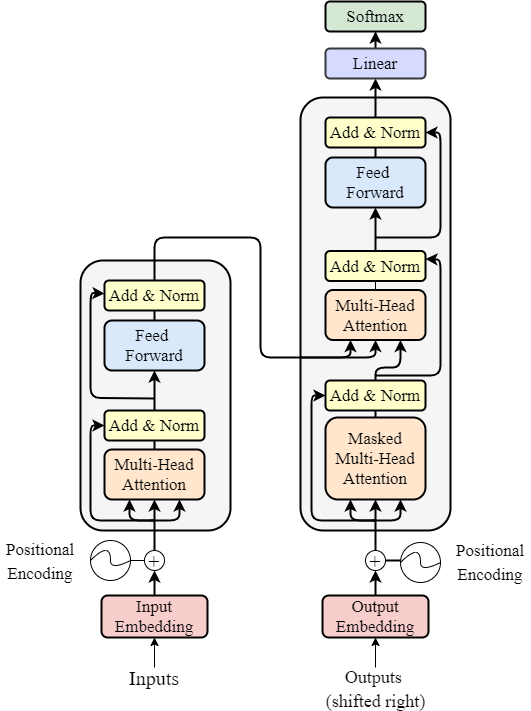

In [3]:
class Embedding(nn.Module):

  def __init__(self, vocab_size, embed_dim):

    super().__init__()
    self.embed = nn.Embedding(vocab_size, embed_dim)

  def forward(self, x):
    embeddings = self.embed(x)
    return embeddings

In [4]:
class PositionalEncoding(nn.Module):
  def __init__(self, max_len, embed_dim):
    """
    Args
    max_len: maximum lenght of sentence
    embed_dim: dimansion of embedding features
    """

    super().__init__()

    # in this class a matrix with the same size of input is added
    # this matrix contains positional information of words

    self.positional_encoding = torch.zeros(max_len, embed_dim, device=device)
    # we do not need backpropagation to update any weight here
    self.positional_encoding.requires_grad = False

    # pos: position of a word in the sentence
    pos = torch.arange(0, max_len, device=device)
    # 1D -> 2D
    pos = pos.float().unsqueeze(dim=1)

    _2i = torch.arange(0, embed_dim, step = 2, device = device).float()

    # calculating positional encodings
    # even positions
    self.positional_encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / embed_dim) ))
    self.positiona_encoding[:, 1::2] = torch.cos(pos / (10000 ** ((_2i + 1) / embed_dim) ))

  def forward(self, x):
    pass